In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
from modules.gridgen import CylinderGridGen, AffineGridGen
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

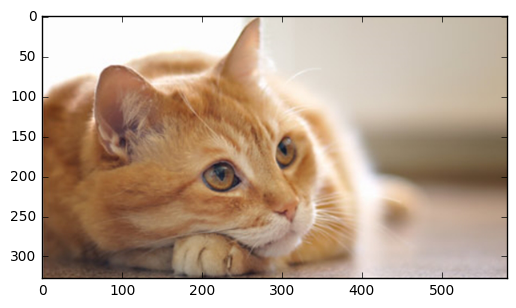

In [2]:
img = Image.open('cat.jpg').convert('RGB')
img = np.array(img)/255.0
plt.imshow(img)

In [3]:
img_batch = np.expand_dims(img, 0)
inputImages = torch.from_numpy(img_batch.astype(np.float32))
inputImages.size()
s = STN()
g = AffineGridGen(328, 582)
input = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.5, 1, 0]]], dtype=np.float32)), requires_grad = True)
#print input
aux_zeros = Variable(torch.zeros(1))
out = g(input)
grid_out = out # save for later use
input1 = Variable(inputImages)
res = s(input1, out)
res = res.data.numpy()

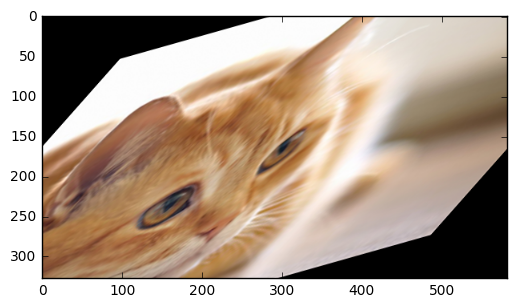

In [4]:
plt.imshow(res[0])

In [5]:
target = Variable(torch.from_numpy(res))

In [6]:
print input1.size(), target.size()

torch.Size([1, 328, 582, 3]) torch.Size([1, 328, 582, 3])


In [7]:
crt = nn.L1Loss()
crt2 = nn.L1Loss()

In [8]:
crt.forward(input1, target)

Variable containing:
 0.2754
[torch.FloatTensor of size 1]

In [9]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.s = STN()
        self.g = AffineGridGen(328, 582, lr = 0.01, aux_loss = True)
    def forward(self,input1, input2):
        out, aux = self.g(input2)
        out2 = self.s(input1, out)
        return out2, aux

In [10]:
t = Transformer()

In [11]:
x = np.arange(0.1, 2, 0.01)
y = []
g_ = []
for v in x:
    input2 = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.48, v, 0]]], dtype=np.float32)) , requires_grad = True)
    out, aux = t(input1, input2)
    err = crt(out, target) + 0.001 * crt2(aux, aux_zeros)
    err.backward()
    y.append(err.data[0])
    #print input2.grad.size()
    g_.append(input2.grad.data[0,1,1])


In [12]:
y[0]

0.19142219424247742

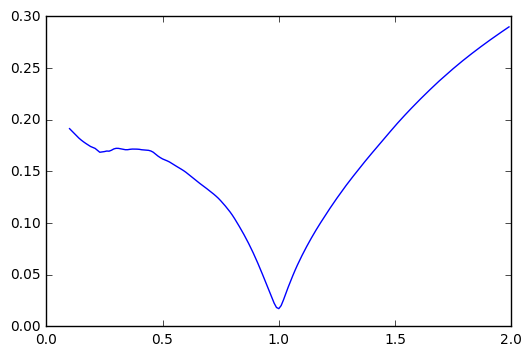

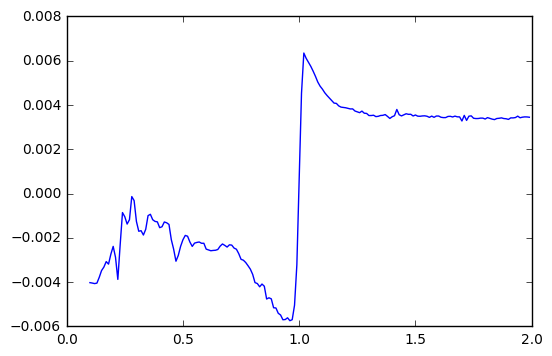

In [13]:
plt.figure()
plt.plot(x,y)
plt.figure()
plt.plot(x,g_)

In [14]:
g = CylinderGridGen(64,128)

In [15]:
s = Variable(torch.zeros([1,1]))

In [16]:
s.data.fill_(2.33)


 2.3300
[torch.FloatTensor of size 1x1]

In [17]:
out = g.forward(s)

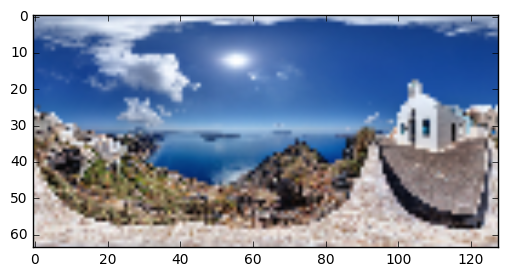

In [18]:
from PIL import ImageFilter
img = Image.open('equi.png').convert('RGB').resize((128,64))
img = np.array(img)/255.0
plt.imshow(img)

In [19]:
input1 = Variable(torch.from_numpy(np.expand_dims(img.astype(np.float32), 0)))

In [20]:
st = STN()

In [21]:
imgout = st(input1, out)

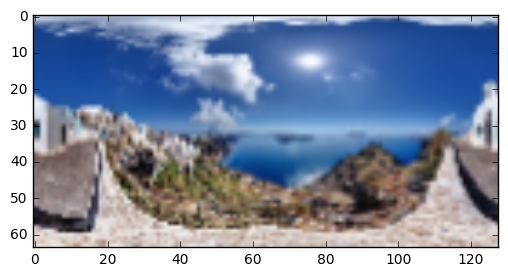

In [22]:
plt.imshow(imgout.data.numpy()[0][:,:,0:3])

In [23]:
class CylinderTransformer(nn.Module):
    def __init__(self):
        super(CylinderTransformer, self).__init__()
        self.s = STN()
        self.g = CylinderGridGen(64, 128, lr = 1, aux_loss=True)
    def forward(self,input1, input2):
        out, aux = self.g(input2)
        out2 = self.s(input1, out)
        return out2, aux

In [24]:
target = imgout
tc = CylinderTransformer()

In [25]:
x = []
y = []
g_ = []

for i in np.arange(0,5,0.001):
    x.append(i)
    input2 = Variable(torch.from_numpy(np.array([[i]], dtype=np.float32)) , requires_grad = True)
    out, aux = tc(input1, input2)
    err = crt(out, target) + 0.001 * crt2(aux, aux_zeros)
    err.backward()
    y.append(err.data[0])
    g_.append(input2.grad.data[0][0])

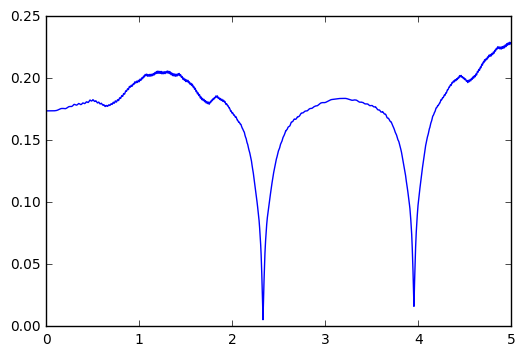

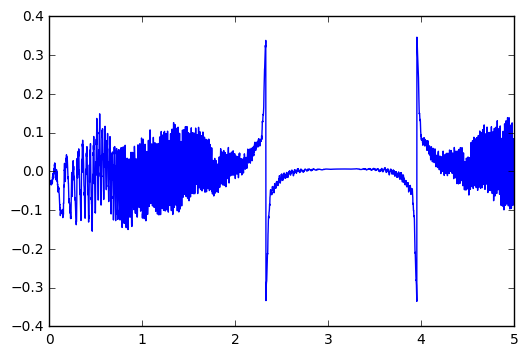

In [26]:
plt.figure()
plt.plot(x,y)
plt.figure()
plt.plot(x,g_)

In [27]:
g__ = []
for i in range(len(np.array(g_))-300):
    g__.append(np.mean(g_[i:i+300]))

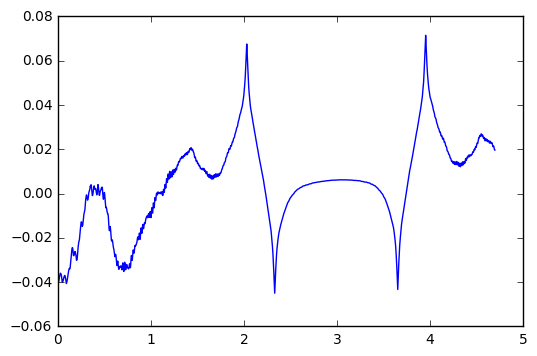

In [28]:
plt.plot(x[:-300], g__)

In [29]:
grid = grid_out.data.numpy()[0]

In [30]:
grid.shape

(328, 582, 2)

In [31]:
delta = 0.025
x = np.arange(-1, 1, 2/582.0)
y = np.arange(-1, 1, 2/328.0)
X, Y = np.meshgrid(x, y)
Z1 = grid[:,:,0]
Z2 = grid[:,:,1]
Z3 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z4 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)

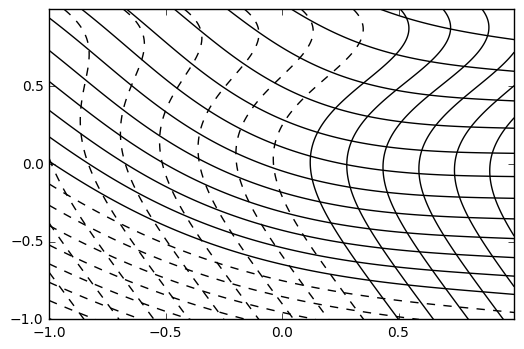

In [32]:
plt.figure()
CS = plt.contour(X, Y, Z1+Z3*5, 20, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)
CS = plt.contour(X, Y, Z2-Z4*5, 20, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)
new_grid = np.concatenate([np.expand_dims(Z1+Z3*5,2), np.expand_dims(Z2-Z4*5,2)],2)
grid_out = Variable(torch.from_numpy(np.expand_dims(new_grid.astype(np.float32), 0)))

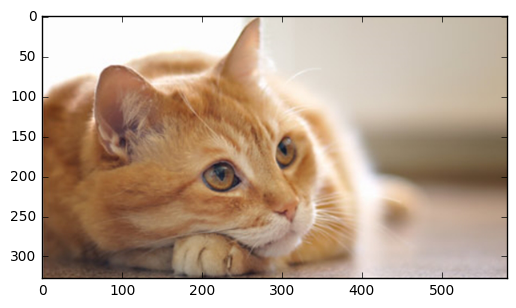

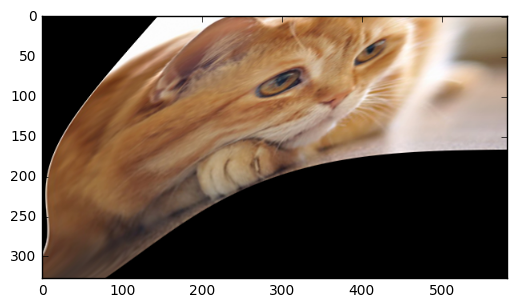

In [34]:
img = Image.open('cat.jpg').convert('RGB')
img = np.array(img)/255.0
plt.figure()
plt.imshow(img)
img_batch = np.expand_dims(img, 0)
inputImages = torch.from_numpy(img_batch.astype(np.float32))
input1 = Variable(inputImages)
s = STN()
res = s(input1, grid_out)
res = res.data.numpy()
plt.figure()
plt.imshow(res[0])